Import the necessary libraries and packages

In [1]:
import pandas as pd

from block_learning.save_bn import save_model
from block_learning.read_bn import read_model
from block_learning.train_bn import train_model
from block_learning.partial_bn_train import partial_model_train
from block_learning.sampling import generate_synthetics
from block_learning.quality_metrics import SRMSE

import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import os.path
from pomegranate import BayesianNetwork, DiscreteDistribution



Load the necessary data.  
The data was collected from the social network VKontakte using an open API.  
The variables are the following: 
## Socio-demographic data 
`age`  
`gender`  
`city` - city code  
`education_status`  
`relation` - marital status  
`relatives` - number of relatives  

## Information about interests  
`love_relation` - the degree of interest in this topic [0,100]  
`sport_fitness` - the degree of interest in this topic [0,100]  
`job_money` - the degree of interest in this topic [0,100]  
`history_politics` - the degree of interest in this topic [0,100]  
`news` - the degree of interest in this topic [0,100]  

## Social network activity metrics
`friends` - number of friends  
`followers` - number of followers  
`avg_likes` - number of likes per post  
`posts` - total number of posts  
`avg_views` - number of views per post  
`repost_ratio` - share of reposts on user page  





In [2]:
vk_data = pd.read_csv('data/modules_vk_discrete.csv')
train_data, test_data = train_test_split(vk_data, test_size=0.1, shuffle=True)

In [3]:
n = test_data.shape[0]
n

1292

The main idea is to build a modular structure of Bayesian networks, where each network represents some level of a person’s personal description.   
An example of such a structure is shown in the picture.

![title](img/modules_scheme.png)

Divide the data into the necessary modules

In [4]:
module1 = train_data[['age','sex','city','education_status','relation','relatives']]
module2 = train_data[['love_relation','sport_fitness','job_money','history_politics','news']]
module3 = train_data[['friends','followers','avg_likes','posts','avg_views','repost_ratio']]

In [5]:
module1.reset_index(drop=True, inplace=True)
module2.reset_index(drop=True, inplace=True)
module3.reset_index(drop=True, inplace=True)

Let's start learning the structure and parameters of the Bayesian network on the first module.  
If the trained model is not in the folder, we can train it and save it as a json file.  
[2, 3, 4, 5, 6] - These are the node numbers that parents can have. Zero and first nodes are not specified, as these are initializing nodes.  
Nodes are numbered in the same way as columns with attributes in the data.                                                                 


In [6]:
bn1 = BayesianNetwork()
if os.path.exists('models/module1__3.json'):
    bn1 = read_model('module1__3')
else:
    bn1 = train_model(data=module1, algorithm='K2', init_nodes=[0,1],clusters=3) 
    save_model(bn1, 'module1__3')





You can see the structure of the model. Each tuple is a collection of node parents.  
As we see, in this structure there were two initializing nodes - age and gender, since they do not have parents.

In [6]:
bn1.structure

((), (), (0,), (5,), (0,), (4,), ())

Now connect the already trained model with the new network structure, which will be trained on the data of the second module.

In [7]:
bn12 = partial_model_train(bn1=bn1, data=module2, algorithm = "K2", init_nodes=[0],clusters=5)
save_model(bn12, 'module12__3')

In [7]:
bn12.structure

((), (3,), (5,), (), (1,), (3,), ())

In [8]:
bn123 = partial_model_train(bn1=bn12, data = module3, algorithm = 'K2', clusters = 3, init_nodes=[0])

In [12]:
bn123.structure

((), (0, 2), (0, 3), (0, 5), (0, 3, 2), (0,), (0, 3, 2, 1), (6, 3, 2, 1))

In [13]:
save_model(bn123, 'module123__3')


The overall block network structure will look something like this.  
![title](img/BN-1.png)

Now you can start sampling the data. Data can be sampled at each level, for example, at the level of the first module.

In [14]:
module1_sample = generate_synthetics(bn1,100)

Save the received data in a numpy.ndarray

In [15]:
module1_synth = []
for key in module1_sample.keys():
    module1_synth.append(module1_sample.get(key))
module1_synth = np.array(module1_synth)
module1_synth = np.transpose(module1_synth)



In [16]:
test_data = test_data.sample(100)

In [17]:
srmse1 = SRMSE(module1_synth, test_data.values, [0, 1, 2, 3])

In [18]:
srmse1

0.8975274678557504

You can look at the marginal distribution of test and sampled data.  
Blue is real data.  

Orange is synthetic data.

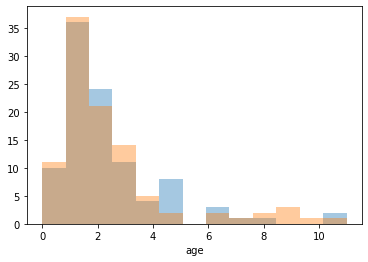

In [19]:
sns.distplot(test_data['age'],kde=False)
sns.distplot(module1_sample[0],kde=False)

In [20]:
module2_sample = generate_synthetics(bn12,100)

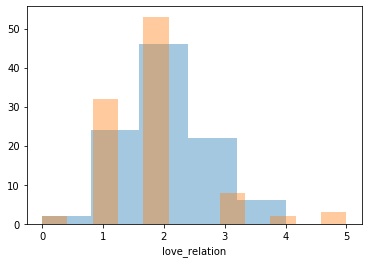

In [21]:
sns.distplot(test_data['love_relation'],kde=False)
sns.distplot(module2_sample[1],kde=False)

In [22]:
module3_sample = generate_synthetics(bn123,100)

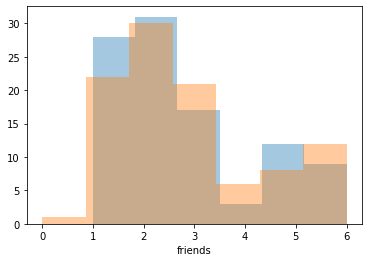

In [23]:
sns.distplot(test_data['friends'],kde=False)
sns.distplot(module3_sample[1],kde=False)

For comparison, let's try to identify the Bayesian network by directly training on all data at once.

In [24]:
bn_direct_learning = read_model('direct_model')

In [25]:
module1_direct_sample = generate_synthetics(bn_direct_learning, 100)

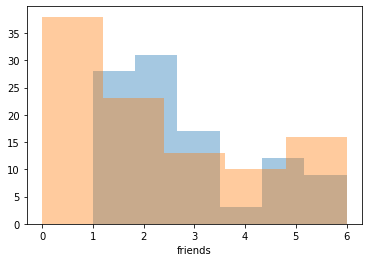

In [26]:
sns.distplot(test_data['friends'],kde=False)
sns.distplot(module1_direct_sample[11],kde=False)

We see that with this method of training, bars with diverging values are larger